# Analytic Bijections

This tutorial demonstrates how to leverage the analytic bijections defined in `bijx`,
first in 1D and then in new radial flows in 2D.

In [ ]:
from flax import nnx
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import bijx

rngs = nnx.Rngs(0)

## 1D Example

We can learn onedimensional distributions by stacking sufficiently many scalar bijections.
First, we'll define a synthetic target distribution as an example.

In [ ]:
@nnx.dataclass
class PolyTarget:
    # Oscillatory Gaussian component coefficients
    a1: nnx.Data[float] = 1.0  # Amplitude of sin term
    w1: nnx.Data[float] = 5.0  # Frequency of sin
    g1: nnx.Data[float] = 5.0  # Gaussian decay rate

    # Cosine component
    a2: nnx.Data[float] = 2.0  # Amplitude of cos term
    w2: nnx.Data[float] = 10.0  # Frequency of cos

    # Polynomial component
    a4: nnx.Data[float] = -0.2

    def __call__(self, x):
        """Compute unnormalized log density."""
        # Handle both (batch,) and (batch, 1) shapes
        x_flat = x.squeeze(-1) if x.shape[-1] == 1 else x

        log_p = (
            self.a1 * jnp.sin(self.w1 * x_flat) * jnp.exp(-self.g1 * x_flat**2)
            + self.a2 * jnp.cos(self.w2 * x_flat)
            + self.a4 * x_flat**4
        )
        return log_p

poly_target = PolyTarget()

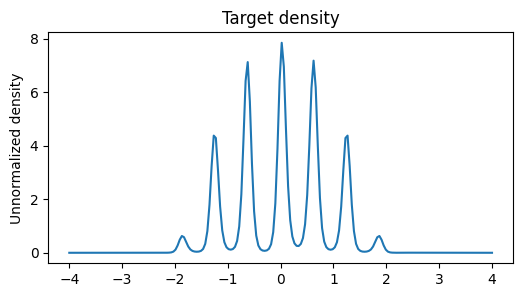

In [ ]:
plt.figure(figsize=(6, 3))
plt.title('Target density')
x = jnp.linspace(-4, 4, 200)
plt.plot(x, jnp.exp(poly_target(x)))
plt.ylabel('Unnormalized density')
plt.show()

### Model

Instead of a for-loop over multiple bijections, we use `bijx.ScanChain` which chains the internal bijection using jax's scan. The internal bijection is expected to have parameters with leading batch dimension, which is achieved by applying `vmap` over a number of random keys.

In [ ]:
stack_size = 64

@nnx.split_rngs(splits=stack_size)
@nnx.vmap(in_axes=(0,), out_axes=0)
def create_bijection_stack(rngs):
    # base = bijx.SinhConjugation(rngs=rngs)
    # base = bijx.CubicRational(rngs=rngs)

    base = bijx.CubicConjugation(rngs=rngs)

    return bijx.ScanChain(base)

In [ ]:
bijection = create_bijection_stack(nnx.Rngs(0))
model = bijx.Transformed(
    bijx.IndependentNormal((), rngs=nnx.Rngs(0)),
    bijection,
)

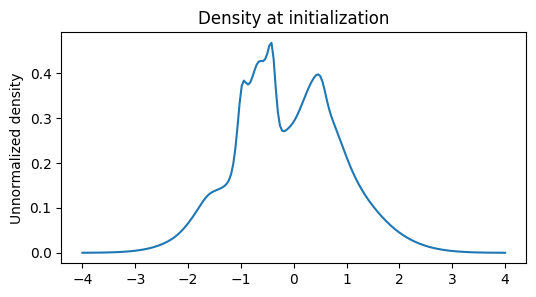

In [ ]:
plt.figure(figsize=(6, 3))
plt.title('Density at initialization')
x = jnp.linspace(-4, 4, 200)
plt.plot(x, jnp.exp(model.log_density(x)))
plt.ylabel('Unnormalized density')
plt.show()

### Training

In [ ]:
# simple training setup
batch_size = 256

optimizer = nnx.Optimizer(
    tx=optax.adam(1e-3),
    model=model,
    wrt=nnx.Param,
)

def loss_fn(model):
    x, lq = model.sample((batch_size,))
    lp = poly_target(x)
    return -jnp.mean(lp - lq)

@nnx.jit
def update_step(model, optimizer):
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads=grads, model=model)
    return loss

100%|██████████| 2000/2000 [00:05<00:00, 341.69it/s]


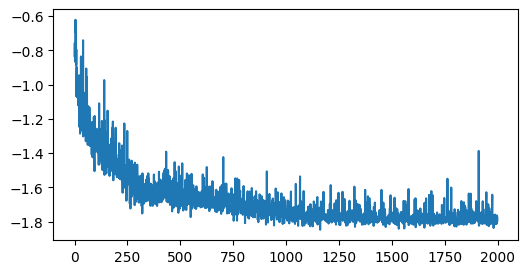

In [ ]:
steps = 2000
losses = np.full(steps, np.nan)

for i in tqdm(range(steps)):
    losses[i] = update_step(model, optimizer)

plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

### Evaluation

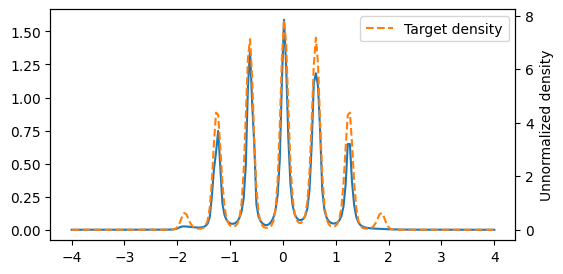

In [ ]:
plt.figure(figsize=(6, 3))
x = jnp.linspace(-4, 4, 200)
plt.plot(x, jnp.exp(model.log_density(x)), label='Learned density')
plt.twinx()
plt.plot(x, jnp.exp(poly_target(x)), '--', label='Target density', color='C1')
plt.ylabel('Unnormalized density')
plt.legend()
plt.show()

## Radial flows

First we define a spiral distribution in 2D, this time by defining how to sample from it.

### Target

In [ ]:
@nnx.dataclass
class SpiralData:

    n_turns: nnx.Data[float] = 2.5  # Number of spiral turns (5 * pi / (2 * pi) = 2.5)
    radius_scale: nnx.Data[float] = 1.0 / 20.0  # Scaling factor for spiral radius
    noise_scale: nnx.Data[float] = 0.02  # Gaussian noise added to spiral
    is_normalized: bool = False  # No density, so not normalized

    @property
    def event_shape(self) -> tuple[int, ...]:
        return (2,)

    def sample(self, batch_shape: tuple[int, ...] = (), *, rng):
        """Generate spiral samples using JAX-compatible operations."""
        total_samples = int(np.prod(batch_shape))

        # Generate parameter t uniformly from 0 to n_turns * 2 * pi
        rng1, rng2 = jax.random.split(rng)
        t = jax.random.uniform(rng1, (total_samples,), minval=0, maxval=self.n_turns * 2 * jnp.pi)

        # Generate spiral coordinates
        x = t * jnp.cos(t) * self.radius_scale
        y = t * jnp.sin(t) * self.radius_scale

        # Add Gaussian noise
        noise = jax.random.normal(rng2, (total_samples, 2)) * self.noise_scale

        # Combine and reshape
        samples = jnp.stack([x, y], axis=1) + noise
        return samples.reshape(*batch_shape, 2)

spiral_data = SpiralData()

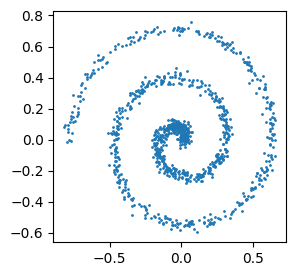

In [ ]:
samples = spiral_data.sample((1000,), rng=jax.random.key(0))
plt.figure(figsize=(3, 3))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

### Model architecture

First, we now want to transfrom radii, with respect to some trainable center.
Thus, we must make sure that we map rays onto rays (i.e. preserve origin).

In [ ]:
stack_size = 64

@nnx.split_rngs(splits=stack_size)
@nnx.vmap(in_axes=(0,), out_axes=0)
def create_bijection_stack(rngs):
    # base = bijx.SinhConjugation(rngs=rngs)
    # base = bijx.CubicRational(rngs=rngs)
    base = bijx.CubicConjugation(rngs=rngs)

    # now wrapped in ray transform
    return bijx.RayTransform(bijx.ScanChain(base))

We will use a simple Fourier-series based coupling layer to make the radial transformation depend on the angle.

In [ ]:
class FourierCondNet(nnx.Module):
    """Fourier-based conditioning network for angle-dependent parameters."""

    def __init__(
        self,
        output_dim: int,
        fourier_count: int = 3,
        hidden_dim: int | None = None,
        *,
        rngs: nnx.Rngs,
    ):
        assert fourier_count % 2 == 1, 'Fourier count must be odd'
        self.kernel = bijx.nn.embeddings.KernelFourier(
            fourier_count, val_range=(-jnp.pi, jnp.pi)
        )
        self.output_dim = output_dim

        if hidden_dim is not None:
            self.hidden = nnx.Linear(
                fourier_count, hidden_dim,
                use_bias=False, rngs=rngs,
                kernel_init=nnx.initializers.normal(0.01),
            )
            final_in = hidden_dim
        else:
            final_in = fourier_count

        self.superpos = nnx.Linear(
            final_in, output_dim,
            use_bias=False, rngs=rngs,
            kernel_init=nnx.initializers.normal(0.01),
        )

    def __call__(self, x_hat):
        """Map unit vectors to bijection parameters.

        Args:
            x_hat: Unit vectors of shape (..., 2).

        Returns:
            Parameters of shape (..., output_dim).
        """
        theta = jnp.atan2(x_hat[..., 1], x_hat[..., 0])
        features = self.kernel(theta)

        # Regularize feature magnitudes: suppress high frequencies
        freq_count = (self.kernel.feature_count - 1) // 2
        freq_indices = jnp.concatenate([
            jnp.arange(1, freq_count + 1),  # for sin terms
            jnp.arange(1, freq_count + 1),  # for cos terms
            jnp.array([1.0])  # for constant term
        ])
        features = features / freq_indices

        if hasattr(self, 'hidden'):
            features = self.hidden(features)
        return self.superpos(features)

In [ ]:
def create_radial_layer(rngs):
    base = create_bijection_stack(rngs)

    cond_net = FourierCondNet(
        output_dim=bijx.ModuleReconstructor(base).params_total_size,
        fourier_count=7,
        rngs=rngs
    )

    layer = bijx.RadialConditional(
        scalar_bijection=base,
        cond_net=cond_net,
        center=jnp.array([-0.5, -1.]),
        scale=jnp.zeros(2),
        rngs=rngs
    )

    return layer


In [ ]:
model = bijx.Transformed(
    bijx.IndependentNormal((2,), rngs=rngs),
    create_radial_layer(rngs)
)

### Training

In [ ]:
# simple training setup
batch_size = 512

optimizer = nnx.Optimizer(
    tx=optax.adam(1e-2),
    model=model,
    wrt=nnx.Param,
)

def loss_fn(model):
    x = spiral_data.sample((batch_size,), rng=model.rngs())
    lq = model.log_density(x)
    return -jnp.mean(lq)

@nnx.jit
def update_step(model, optimizer):
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads=grads, model=model)
    return loss

100%|██████████| 5000/5000 [00:33<00:00, 148.29it/s]


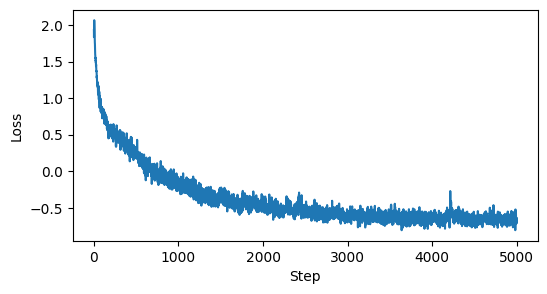

In [ ]:
steps = 5000
losses = np.full(steps, np.nan)

for i in tqdm(range(steps)):
    losses[i] = update_step(model, optimizer)

plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

### Evaluation

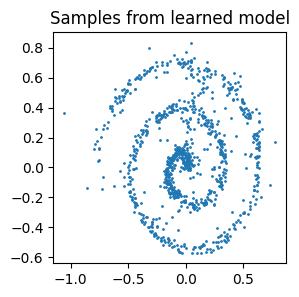

In [ ]:
x, _ = model.sample((1000,))
plt.figure(figsize=(3, 3))
plt.title('Samples from learned model')
plt.scatter(x[:, 0], x[:, 1], s=1)
plt.show()